# **import** ◀

In [17]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 967, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 967 (delta 14), reused 16 (delta 8), pack-reused 936 (from 1)
Receiving objects: 100% (967/967), 128.94 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [18]:

###

import os
import cv2

from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/segment-anything-2')

###


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install .

Processing /content/segment-anything-2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp310-linux_x86_64.whl size=508427 sha256=f51c5fb5aef1dddd4a31f29dda86e7698631115edad40fd415f51cb58340d457
  Stored in directory: /root/.cache/pip/wheels/7d/af/fe/c05425a1fdc391329545b53111d5cabdfc241ee07cab053945
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0


# **setup** ◀

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

###

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


using device: cuda


In [2]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)


def return_anns_bw(anns, borders=False):
  if len(anns) == 0:
        return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  # ax = plt.gca()
  # ax.set_autoscale_on(False)

  img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 3))
  first_ann = True  # Flag to track the first annotation
  for ann in sorted_anns:
      m = ann['segmentation']
      if first_ann:
          img[m] = (0, 0, 0)  # Set first annotation to black
          first_ann = False
      else:
          img[m] = (255, 255, 255)  # Set other annotations to white
      if borders:
          # import cv2
          contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
          cv2.drawContours(img, contours, -1, (0, 0, 0), thickness=1)

  image = cv2.resize(img, (256, 256))
  return image/255

In [3]:
n = 32/36
print(n)
print(int(n))

0.8888888888888888
0


In [17]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# sam2_checkpoint = "/content/drive/MyDrive/SAM2/sam2.1_hiera_base_plus.pt"
# model_cfg = "sam2.1_hiera_b+.yaml"

sam2_checkpoint = "/content/drive/MyDrive/SAM2/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.6,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=2,
    box_nms_thresh=0.6,
    crop_n_points_downscale_factor=5,
    min_mask_region_area=5.0,
    use_m2m=False,
)

# **try it**

In [18]:

import os
import cv2

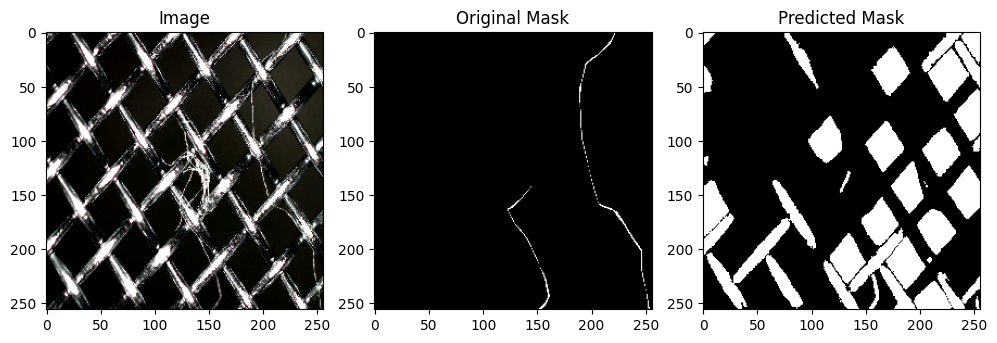

In [19]:

image = Image.open("/content/drive/MyDrive/dataset/2_test/01925.jpg")
image = np.array(image.convert("RGB"))
image = cv2.resize(image, (256, 256))


mask = Image.open("/content/drive/MyDrive/dataset/2_test_bi/01925.jpg")
mask = np.array(mask)
mask = cv2.resize(mask, (256, 256))

predicted = mask_generator_2.generate(image)
ann = return_anns_bw(predicted)


def prepare_plot(origImage, origMask, predMask):

  # initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

  # plot the original image, its mask, and the predicted mask: tutte già resizate
  ax[0].imshow(origImage)
  ax[1].imshow(origMask)
  ax[2].imshow(predMask)

  # set the titles of the subplots
  ax[0].set_title("Image")
  ax[1].set_title("Original Mask")
  ax[2].set_title("Predicted Mask")
  # set the layout of the figure and display it
  figure.tight_layout()
  figure.show()
  print("\n\n")

prepare_plot(image, mask, ann)

# **test** ◀

## functions

In [21]:
# Funzione per calcolare la precision
def precision(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  return tp / (tp + fp + 1e-10)

# Funzione per calcolare la recall
def recall(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fn + 1e-10)

# Funzione per calcolare la F1-score
def f1_score(mask_img, predicted_img, treshold):
  precision_value = precision(mask_img, predicted_img, treshold)
  recall_value = recall(mask_img, predicted_img, treshold)
  return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)

# Funzione per calcolare l'Intersection over Union (IoU)
def iou(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fp + fn + 1e-10)

In [22]:

def prepare_plot(origImage, origMask, predMask):

  # initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

  # plot the original image, its mask, and the predicted mask: tutte già resizate
  ax[0].imshow(origImage)
  ax[1].imshow(origMask)
  ax[2].imshow(predMask)

  # set the titles of the subplots
  ax[0].set_title("Image")
  ax[1].set_title("Original Mask")
  ax[2].set_title("Predicted Mask")
  # set the layout of the figure and display it
  figure.tight_layout()
  figure.show()



def make_predictions(model, imagePath, maskPath, device):

	#originale
	image = Image.open(imagePath)
	image = np.array(image.convert("RGB"))
	image = cv2.resize(image, (256, 256))

	#mask
	filename = imagePath.split(os.path.sep)[-1]
	groundTruthPath = os.path.join(maskPath,filename)
	mask = Image.open(groundTruthPath)
	mask = np.array(mask)
	mask = cv2.resize(mask, (256, 256))

	#predetta
	predicted = model.generate(image)
	ann = return_anns_bw(predicted)

	return image, mask, ann




def random_test_evaluation(model, number_of_images):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	image_paths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	imagePaths = np.random.choice(image_paths, size=number_of_images)

	threshold = 0.5

	# iterate over the randomly selected test image paths
	for path in imagePaths:

		print(path)

		# make predictions
		orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

		print(f"Precision: {precision(gtMask, predMask, threshold)}")
		print(f"Recall: {recall(gtMask, predMask, threshold)}")
		print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
		print(f"IoU: {iou(gtMask, predMask, threshold)}")




def full_test_evaluation(model):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	data_graph = '/content/drive/MyDrive/SAM2-base/grafici/'
	#imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

	precision_list = []
	recall_list = []
	f1_list = []
	iou_list = []
	treshold = 0.5

	empty_array = np.empty(0)
	np.save(data_graph + 'precision_list.npy', empty_array)
	np.save(data_graph + 'recall_list.npy', empty_array)
	np.save(data_graph + 'f1_list.npy', empty_array)
	np.save(data_graph + 'iou_list.npy', empty_array)


	# iterate over the test image paths: 202 images
	for path in sorted(os.listdir(IMAGE_TEST_PATH)):

		# make predictions
		orig, gtMask, predMask = make_predictions(model, os.path.join(IMAGE_TEST_PATH, path), MASK_TEST_PATH, device)

		precision_list.append(precision(gtMask, predMask, treshold))
		recall_list.append(recall(gtMask, predMask, treshold))
		f1_list.append(f1_score(gtMask, predMask, treshold))
		iou_list.append(iou(gtMask, predMask, treshold))

		if len(precision_list) % 10 == 0:
			print(len(precision_list))
			#salva ciscuna lista in file npy sovrascrivendola
			with open(data_graph + 'precision_list.npy', 'wb') as f:
					np.save(f, np.array(precision_list))
			with open(data_graph + 'recall_list.npy', 'wb') as f:
					np.save(f, np.array(recall_list))
			with open(data_graph + 'f1_list.npy', 'wb') as f:
					np.save(f, np.array(f1_list))
			with open(data_graph + 'iou_list.npy', 'wb') as f:
					np.save(f, np.array(iou_list))

	return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(iou_list)


## usage

In [ ]:
# usage FULL

full_test_evaluation(mask_generator_2)

/content/segment-anything-2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/content/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


(0.14827490938437823,
 0.31420922400981505,
 0.12010318092491322,
 0.07465380328700132)

In [ ]:
#usage RANDOM

random_test_evaluation(mask_generator_2, 3)

## 4 std imagest evaluation

In [23]:

def _4_random_test_evaluation(model):

  # load the image paths in our testing file and randomly select n image paths
  IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
  MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
  names = ['01104.jpg','00007.jpg','01925.jpg','01760.jpg']
  imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in names if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]

  threshold = 0.5

  # iterate over the randomly selected test image paths
  for path in imagePaths:

    print(path)

    # make predictions
    orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    print(f"Precision: {precision(gtMask, predMask, threshold)}")
    print(f"Recall: {recall(gtMask, predMask, threshold)}")
    print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
    print(f"IoU: {iou(gtMask, predMask, threshold)}")

    # prepare a plot for visualization
    prepare_plot(orig, gtMask, predMask)



/content/drive/MyDrive/dataset/2_test/01104.jpg
Precision: 0.02259179265658744
Recall: 0.5024015369836534
F1-Score: 0.04323922118972993
IoU: 0.022097346628358935
/content/drive/MyDrive/dataset/2_test/00007.jpg
Precision: 0.21649484536078753
Recall: 0.1333333333333192
F1-Score: 0.16502946950093753
IoU: 0.08993576017129978
/content/drive/MyDrive/dataset/2_test/01925.jpg
Precision: 0.006101409636019345
Recall: 0.18012422360247515
F1-Score: 0.011803011796673745
IoU: 0.0059365404298874005
/content/drive/MyDrive/dataset/2_test/01760.jpg
Precision: 0.6816151842203159
Recall: 0.5060091172813902
F1-Score: 0.5808293030510664
IoU: 0.4092737430167583


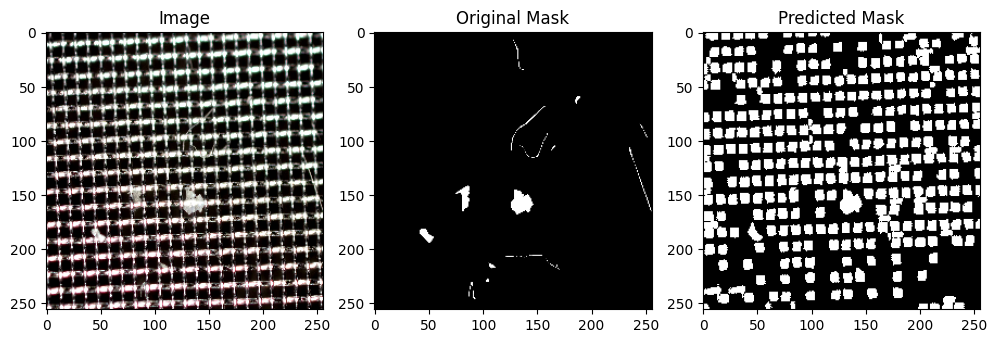

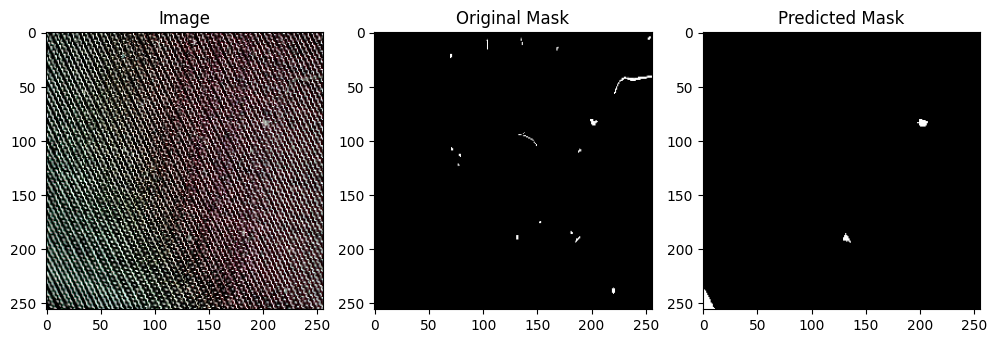

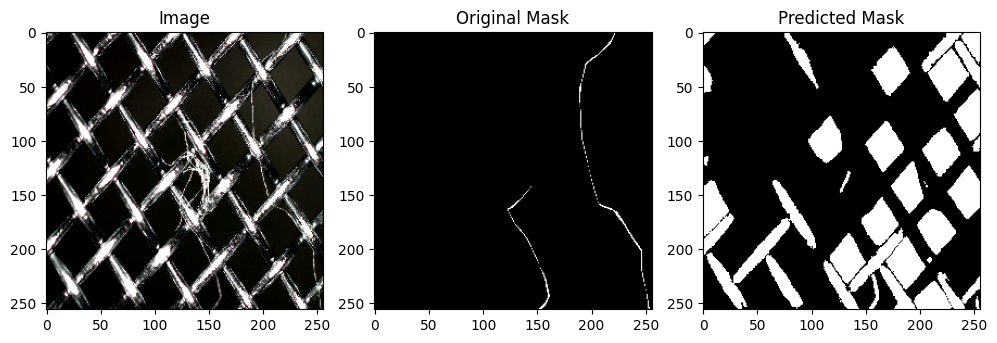

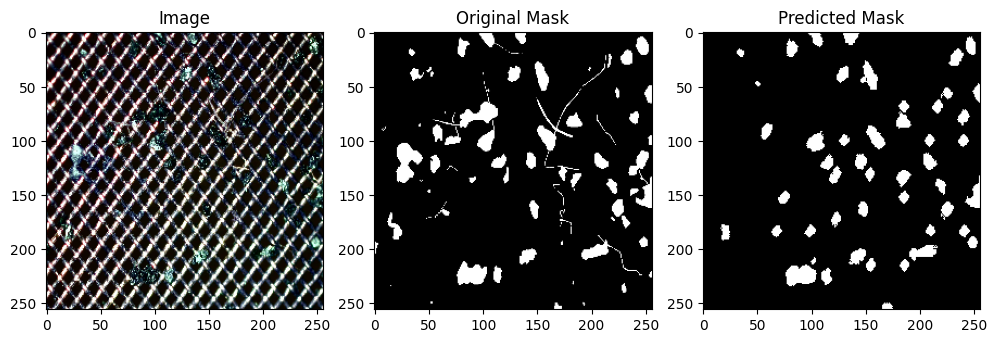

In [24]:
#usage RANDOM

_4_random_test_evaluation(mask_generator_2)

# GRAFICI

## **GRAFICI MEDIA ARITMETICA**

In [27]:
data_graph = '/content/drive/MyDrive/SAM2/grafici/'

(200,)


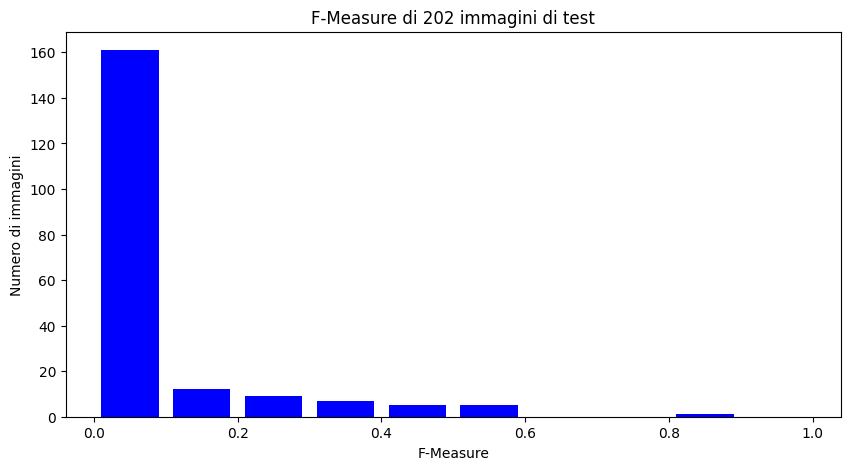

In [28]:
f1 = np.load(data_graph + 'f1_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(f1, bins, value, color = 'blue', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('F-Measure di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

(200,)


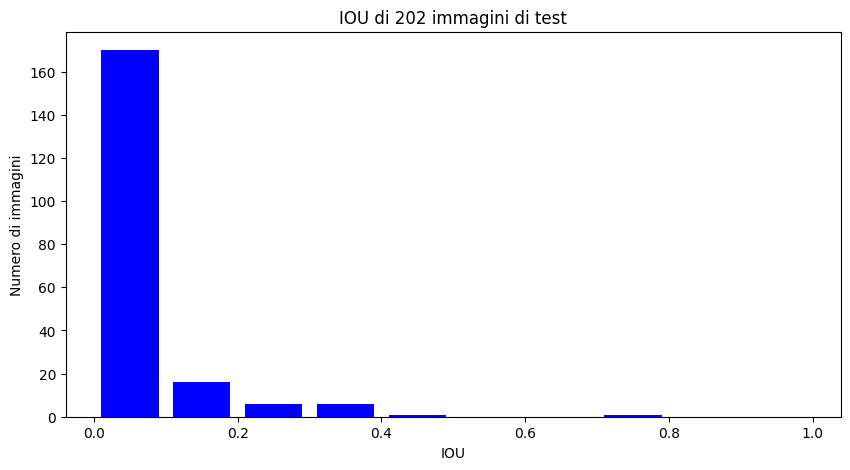

In [29]:
iou = np.load(data_graph + 'iou_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(iou, bins, value, color = 'blue', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('IOU')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('IOU di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

## **GRAFICI MEDIA TRONCATA**

(202,)


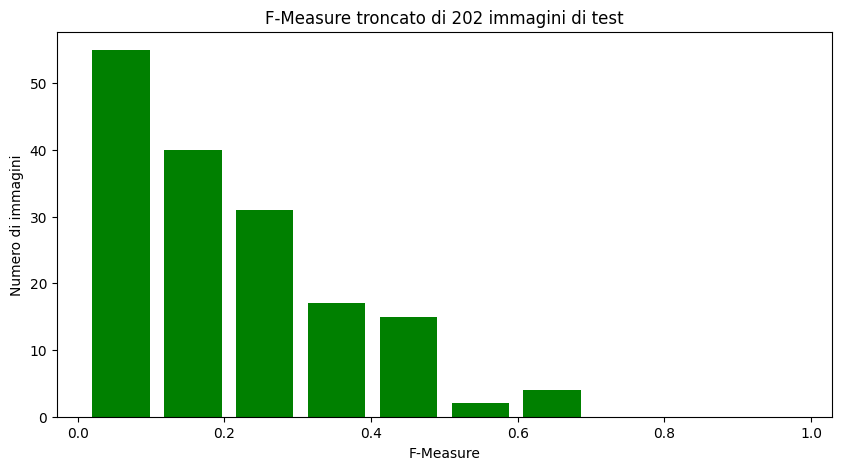

In [ ]:
f1 = np.load(data_graph + 'f1_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0.01,0.99)     # Media troncata eliminando valori estremi
bins = 10

# Plot di un istogramma
plt.hist(f1, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('F-Measure troncato di 202 immagini di test')

#fig.savefig(data_graph + 'fm-troncato.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

(202,)


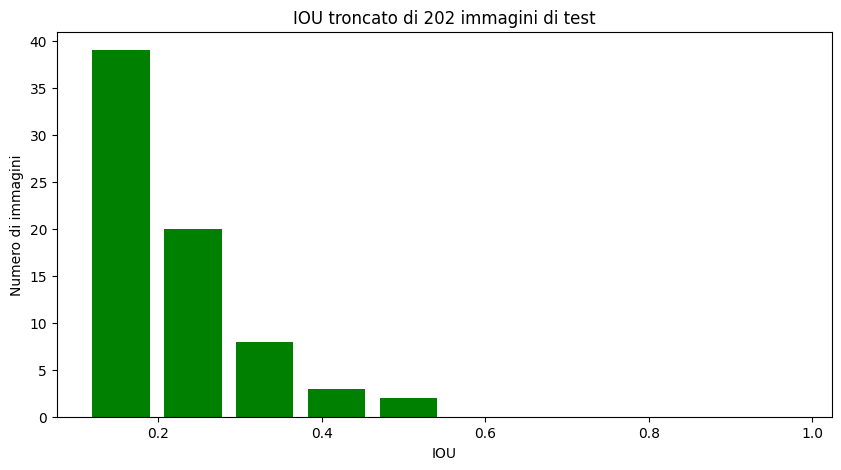

In [ ]:
iou = np.load(data_graph + 'iou_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0.11, 0.99)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(iou, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('IOU')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('IOU troncato di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()